# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium

In [218]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [498]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/2000,-60.7220,153.6700,6.0,2000
1,01/02/2000,-17.9430,-178.4760,5.5,2000
2,01/02/2000,51.4470,-175.5580,5.8,2000
3,01/02/2000,-20.7710,-174.2360,5.8,2000
4,01/05/2000,-20.9640,-174.0970,5.6,2000
...,...,...,...,...,...
8739,12/28/2016,38.3917,-118.8941,5.6,2016
8740,12/28/2016,38.3777,-118.8957,5.5,2016
8741,12/28/2016,36.9179,140.4262,5.9,2016
8742,12/29/2016,-9.0283,118.6639,6.3,2016


##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [278]:
f_true = _df.loc[:,"Magnitude"]

In [279]:
f = f_true + np.random.normal(scale=0.2,size=len(f_true))

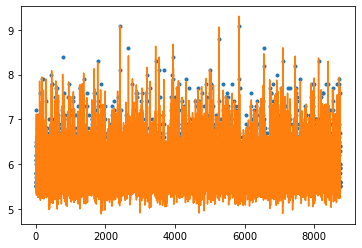

In [222]:
plt.plot(f_true,'.')
plt.plot(f,'-')

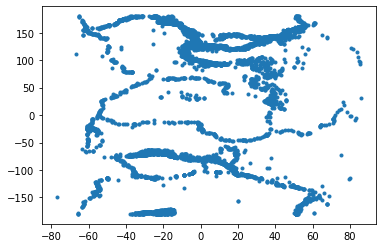

In [223]:
plt.plot( _df.Latitude,_df.Longitude,'.')

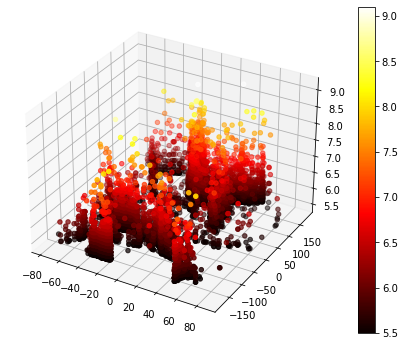

In [615]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [624]:
_dfgraph = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:].reset_index()

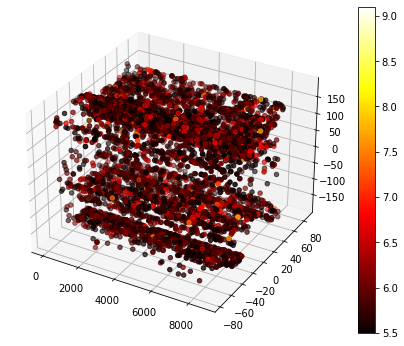

In [629]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_dfgraph.index,_dfgraph.Latitude, _dfgraph.Longitude, c= _dfgraph.Magnitude, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [494]:
from mpl_toolkits.basemap import Basemap

In [226]:
#collapse

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

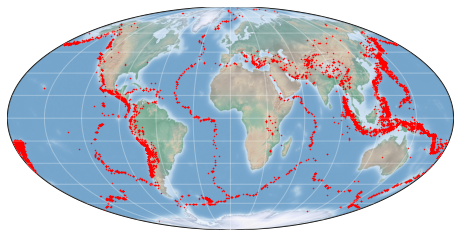

In [227]:
#collapse

fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

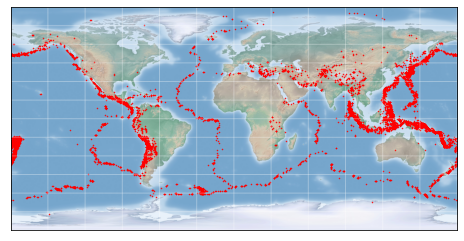

In [228]:
#collapse

fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

In [229]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [230]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [231]:
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2000,2016))).add_to(m)
m

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [232]:
def dist(i,j):
    if abs( _df.Latitude[j] - _df.Latitude[i] ) >= 90: 
        return 10000  
    if abs( _df.Longitude[j] - _df.Longitude[i] ) >= 90: 
        return 10000
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1)
- 연결강도로 생각

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [233]:
def weight(i,j,theta=100,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [234]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [235]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.   , 0.823, 0.   ],
       [0.   , 1.   , 0.786, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.786, 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 1.   , 0.879, 1.   ],
       [0.823, 0.   , 0.   , ..., 0.879, 1.   , 0.875],
       [0.   , 0.   , 0.   , ..., 1.   , 0.875, 1.   ]])

(array([[4898.,    0.,    0., ...,  968., 1575.,  615.],
        [6840.,    0.,    0., ...,  571.,  165.,  930.],
        [6961.,    0.,    0., ...,  946.,  168.,  258.],
        ...,
        [3661.,    0.,    0., ...,  306., 1702., 2807.],
        [3436.,    0.,    0., ...,  313., 1974., 2883.],
        [3668.,    0.,    0., ...,  302., 1739., 2763.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 8744 BarContainer objects>)

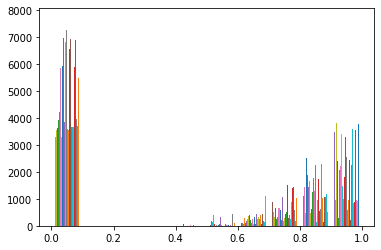

In [236]:
plt.hist(W)

그래프

링크의 방향성이 없는 네트워크 nx.Graph

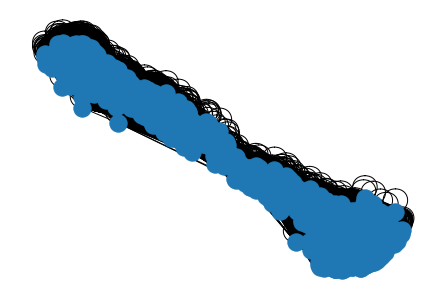

In [237]:
nx.draw(nx.Graph(W))
# 저장하고 싶으면
# plt.show(
# plt.savefig("networkGraph.png")

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [238]:
D = np.diag(W.sum(axis=1))

In [239]:
D

array([[3106.24657496,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , 1654.01767128,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , 1371.12895284, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 4543.00508374,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        4798.2194415 ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 4529.4440886 ]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [240]:
L = D - W

In [241]:
L

array([[ 3.10524657e+03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -8.22930703e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.65301767e+03, -7.85704634e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.85704634e-01,  1.37012895e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.54200508e+03, -8.78769584e-01, -9.99940088e-01],
       [-8.22930703e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -8.78769584e-01,  4.79721944e+03, -8.74907815e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.99940088e-01, -8.74907815e-01,  4.52844409e+03]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$
- $\Psi^\top \Psi = I$

In [242]:
λ, Ψ = np.linalg.eig(L)

In [243]:
Λ = np.diag(λ)

##### 8. p
- $compk = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
- $p = (sum(comp1^2),sum(comp2^2),…,sum(comp8000^2))$
- $p = p/sum(p)$
    - 0.2 0.1  ...
- —> 5개의 최상의 컴포넌트만 골랐더니 70%

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbillw2%2Fbtrb1cbK8V4%2FIaZfk4NCOKZ7BEKVvXi8m1%2Fimg.jpg)

https://greeksharifa.github.io/machine_learning/2021/08/14/GFT/

https://ahjeong.tistory.com/14

In [244]:
def comp(i):
    return (f @ np.outer( Ψ[:,i], Ψ[:,i]))

In [354]:
comp(0)

array([5.88016047, 5.88016047, 5.88016047, ..., 5.88016047, 5.88016047,
       5.88016047])

In [245]:
def p(i):
    return sum(comp(i)**2)

In [355]:
p(0)

302335.0551776319

In [384]:
p_sum = sum(np.array([p(i) for i in range(1,len(_df))]))

In [385]:
array_1 = np.array([p(i) for i in range(1,len(_df))])

In [387]:
np.argsort(array_1)[0:10]

array([8489, 3482, 1416, 8111, 7030, 2372, 4816, 7868, 7568, 7100])

In [396]:
(sum(array_1[np.argsort(array_1)][0:10])/p_sum).round(3)

0.0

In [391]:
np.argsort(array_1)[-10:-1]

array([1243, 5266, 3664, 4545, 2206, 8614, 4275, 6497, 6150])

In [395]:
((array_1[np.argsort(array_1)][-10:-1])/p_sum).round(3)

array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003])

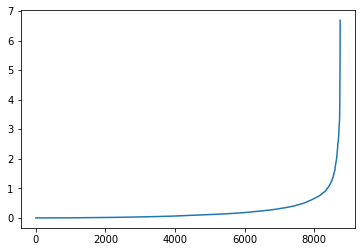

In [397]:
plt.plot(array_1[np.argsort(array_1)])

(0.0, 40.0)

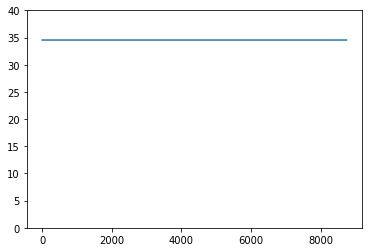

In [267]:
plt.plot( (f @ np.outer( Ψ[:,0], Ψ[:,0]))**2)
plt.ylim(0,40)

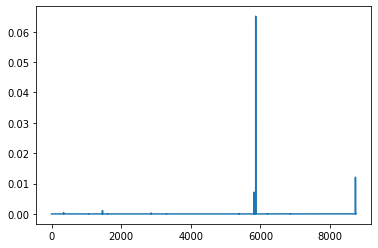

In [310]:
plt.plot( (f @ np.outer( Ψ[:,6150], Ψ[:,6150]))**2)

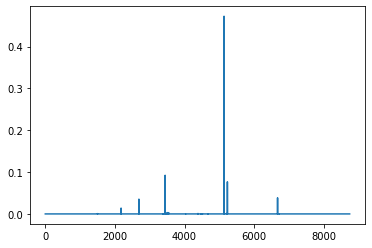

In [312]:
plt.plot( (f @ np.outer( Ψ[:,2837], Ψ[:,2837]))**2)

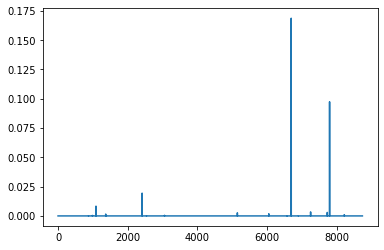

In [311]:
plt.plot( (f @ np.outer( Ψ[:,8614], Ψ[:,8614]))**2)

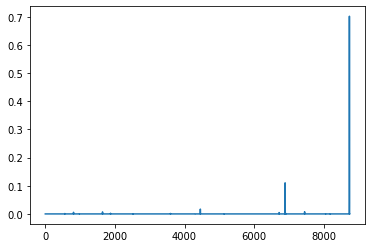

In [313]:
plt.plot( (f @ np.outer( Ψ[:,2459], Ψ[:,2459]))**2)

---

GCN

In [473]:
def g(i):
    return np.exp(-5*λ[i])

In [491]:
g_i = np.array([g(i) for i in range(len(_df))])

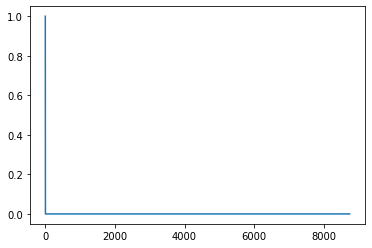

In [492]:
plt.plot(g_i)

In [482]:
sum(g(0)*(f @ np.outer( Ψ[:,0], Ψ[:,0]))*Ψ[:,0])

-549.850029715897

---

##### 9. PCA

In [443]:
comp1 = f @ np.outer( Ψ[:,0], Ψ[:,0])

In [444]:
np.argsort(array_1)[-5:-1]

array([8614, 4275, 6497, 6150])

In [446]:
comp2 = f @ np.outer( Ψ[:,6150], Ψ[:,6150])

In [447]:
comp3 = f @ np.outer( Ψ[:,6497], Ψ[:,6497])

In [448]:
comp4 = f @ np.outer( Ψ[:,4275], Ψ[:,4275])

In [449]:
comp5 = f @ np.outer( Ψ[:,8614], Ψ[:,8614])

In [450]:
___df = _df

In [451]:
___df["comp1"] = comp1

In [452]:
___df["comp2"] = comp2

In [453]:
___df["comp3"] = comp3

In [454]:
___df["comp4"] = comp4

In [455]:
___df["comp5"] = comp5

In [456]:
#collapse
_lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [457]:
#collapse
__lst1=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,4]].\
to_numpy().tolist() for i in range(2016-2000)]

In [458]:
#collapse
__lst2=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,5]].\
to_numpy().tolist() for i in range(2016-2000)]

In [459]:
#collapse
__lst3=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,6]].\
to_numpy().tolist() for i in range(2016-2000)]

In [460]:
#collapse
__lst4=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,7]].\
to_numpy().tolist() for i in range(2016-2000)]

In [461]:
#collapse
__lst5=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,8]].\
to_numpy().tolist() for i in range(2016-2000)]

In [462]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [463]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [464]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [465]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [466]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

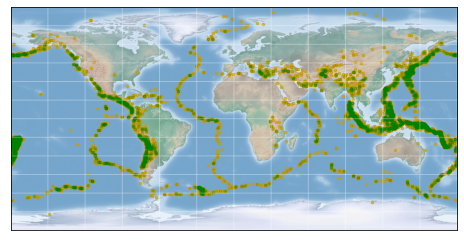

In [467]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 1
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x, y, color='orange', s=abs(f[0])*scale, alpha=abs(f[0])*0.1)
#m.scatter(x, y, color='violet', s=abs(f[np.argsort(p_sum)[-2]])*scale)
#m.scatter(x, y, color='purple', s=abs(f[np.argsort(p_sum)[-3]])*scale)
draw_map(m)

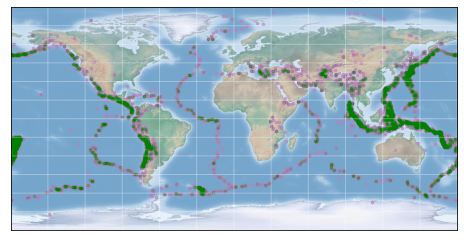

In [468]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 1
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.scatter(x, y, color='orange', s=abs(f[np.argsort(p_sum)[-1]])*scale)
m.scatter(x, y, color='violet', s=abs(f[np.argsort(array_1)[-1]])*scale,alpha=abs(f[np.argsort(array_1)[-1]])*0.1)
#m.scatter(x, y, color='purple', s=abs(f[np.argsort(p_sum)[-3]])*scale)
draw_map(m)

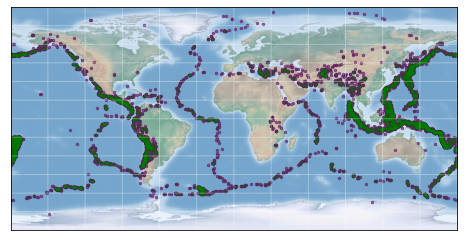

In [441]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 1
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.scatter(x, y, color='orange', s=abs(f[np.argsort(p_sum)[-1]])*scale)
#m.scatter(x, y, color='violet', s=abs(f[np.argsort(p_sum)[-2]])*scale)
m.scatter(x, y, color='purple', s=abs(f[np.argsort(array_1)[0]])*scale,alpha=abs(f[np.argsort(array_1)[-2]])*0.1)
draw_map(m)

component1 빼고 component2 추정

---

ref: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html